In [31]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat


In [1]:
# File paths
base_folder = r'F:\AlterG\Control\Data'
normative_traces_folder = r'F:\AlterG\NormativeTraces'
save_folder = r'F:\AlterG\IndividualKinematics'


In [33]:
# Step 1: Load Participant Data
def load_participant_data(data_directory):
    participants_data = {}
    for file in os.listdir(data_directory):
        if file.endswith(".pkl"):
            with open(os.path.join(data_directory, file), 'rb') as f:
                participants_data[file] = pickle.load(f)
    return participants_data


In [34]:
def display_headers(participant_data):
    if participant_data is not None:
        if isinstance(participant_data, dict):
            headers = list(participant_data.keys())
        else:
            headers = participant_data.dtype.names if participant_data.dtype.names else []
        
        print("Available Headers:")
        for header in headers:
            print(f"- {header}")
    else:
        print("No data available to display headers.")

In [4]:
def load_all_participants(participant_numbers):
    all_data = {}
    for participant_number in participant_numbers:
        participant_data = load_participant_data(participant_number)
        if participant_data:
            all_data[participant_number] = participant_data
    return all_data


In [5]:
def concatenate_strides_across_participants(all_data):
    """
    Concatenates strides per header across all participants.

    Parameters:
    - all_data: Dictionary with participant numbers as keys and their data as values.

    Returns:
    - concatenated_data: Dictionary with headers as keys and concatenated strides as values.
    """
    concatenated_data = {}

    for participant_number, participant_data in all_data.items():
        for header, stride_data in participant_data.items():
            header_type = stride_data.get('header_type', 'unknown')
            if header not in concatenated_data:
                concatenated_data[header] = {
                    'header_type': header_type,
                    'strides_r': [],
                    'strides_l': []
                }
            # Concatenate right strides
            if 'strides_r' in stride_data:
                concatenated_data[header]['strides_r'].extend(stride_data['strides_r'])
            # Concatenate left strides
            if 'strides_l' in stride_data:
                concatenated_data[header]['strides_l'].extend(stride_data['strides_l'])

    return concatenated_data


In [35]:
def plot_concatenated_strides(concatenated_data, header, side=None, variability_type='CI'):
    """
    Plots concatenated strides for the specified header across all participants, including events.

    Parameters:
    - concatenated_data: Dictionary with concatenated strides per header.
    - header: The header to plot.
    - side: 'Right' or 'Left' (optional).
    - variability_type: 'SD', 'SE', or 'CI' (default 'CI').
    """
    if header in concatenated_data:
        stride_data = concatenated_data[header]
        header_type = stride_data.get('header_type', 'unknown')

        # Determine the side key based on 'r' or 'l'
        if side is None:
            if header_type == 'right_only':
                side = 'Right'
            elif header_type == 'left_only':
                side = 'Left'
            elif header_type == 'bilateral':
                side = input("Enter side ('Right' or 'Left'): ")
                if side not in ['Right', 'Left']:
                    print("Invalid side. Please enter 'Right' or 'Left'.")
                    return
            else:
                print(f"Unknown header type for '{header}'.")
                return

        # Map 'Right'/'Left' to 'r'/'l' to match your data keys
        side_key = 'r' if side.lower() == 'right' else 'l'

        # Access the correct strides list
        strides = stride_data.get(f'strides_{side_key}', [])

        if strides:
            # Check if strides are dictionaries
            if isinstance(strides[0], dict):
                stride_arrays = [s['processed_stride_data'] for s in strides]
                event_lists = [s.get('normalized_events', []) for s in strides]
            else:
                stride_arrays = strides
                event_lists = [[] for _ in strides]  # Empty events if not available

            # Create two subplots side by side
            fig, axs = plt.subplots(1, 2, figsize=(14, 6))

            # Left Plot: All individual strides with events
            axs[0].set_title(f'{header} - {side} Side - All Strides')
            axs[0].set_xlabel('% Gait Cycle')
            axs[0].set_ylabel(header)
            x_values = np.linspace(0, 100, len(stride_arrays[0]))

            # Define event styles
            event_styles = {
                'ipsi_toe_off': {'color': 'green', 'linestyle': '--', 'label': 'Ipsi Toe Off'},
                'contra_heel_strike': {'color': 'blue', 'linestyle': '-.', 'label': 'Contra Heel Strike'},
                'contra_toe_off': {'color': 'purple', 'linestyle': ':', 'label': 'Contra Toe Off'},
                # Add more event types as needed
            }
            # Keep track of plotted event types for legend
            plotted_event_types = {}

            for stride, events in zip(stride_arrays, event_lists):
                axs[0].plot(x_values, stride, alpha=0.1)  # Lower alpha for large datasets

                # Plot normalized events as vertical lines
                for event in events:
                    event_idx = event.get('normalized_index')
                    event_type = event.get('type', 'Event')
                    if event_idx is not None and 0 <= event_idx < len(x_values):
                        event_position = x_values[event_idx]
                        style = event_styles.get(event_type, {'color': 'gray', 'linestyle': '--', 'label': event_type})
                        axs[0].axvline(x=event_position, color=style['color'], linestyle=style['linestyle'], alpha=0.5)
                        # Add to legend only once
                        if event_type not in plotted_event_types:
                            plotted_event_types[event_type] = style['label']

            # Add legend for events
            if plotted_event_types:
                handles = [plt.Line2D([0], [0], color=event_styles[etype]['color'],
                                      linestyle=event_styles[etype]['linestyle'],
                                      label=label)
                           for etype, label in plotted_event_types.items()]
                axs[0].legend(handles=handles, loc='upper right')

            axs[0].grid(True)

            # Right Plot: Mean stride with variability
            mean_stride, lower, upper = compute_mean_and_variability(
                [{'processed_stride_data': s} for s in stride_arrays], variability=variability_type
            )
            if mean_stride is not None:
                axs[1].set_title(f'{header} - {side} Side - Mean ± {variability_type}')
                axs[1].set_xlabel('% Gait Cycle')
                axs[1].set_ylabel(header)
                x_values_mean = np.linspace(0, 100, len(mean_stride))
                axs[1].plot(x_values_mean, mean_stride, color='red', label='Mean')
                axs[1].fill_between(x_values_mean, lower, upper, color='red', alpha=0.2, label=f'{variability_type}')
                axs[1].legend()
                axs[1].grid(True)

                # Optionally, plot mean event positions
                # Collect all normalized event indices by event type
                event_indices_by_type = {}
                for events in event_lists:
                    for event in events:
                        event_idx = event.get('normalized_index')
                        event_type = event.get('type', 'Event')
                        if event_idx is not None:
                            event_indices_by_type.setdefault(event_type, []).append(event_idx)

                # Plot mean event positions
                for event_type, indices in event_indices_by_type.items():
                    mean_event_idx = int(np.mean(indices))
                    event_position = x_values_mean[mean_event_idx]
                    style = event_styles.get(event_type, {'color': 'gray', 'linestyle': '--', 'label': event_type})
                    axs[1].axvline(x=event_position, color=style['color'], linestyle=style['linestyle'],
                                   alpha=0.8, label=style['label'])

                # Add legend for mean events
                if event_indices_by_type:
                    handles = [plt.Line2D([0], [0], color=event_styles[etype]['color'],
                                          linestyle=event_styles[etype]['linestyle'],
                                          label=event_styles[etype]['label'])
                               for etype in event_indices_by_type]
                    axs[1].legend(handles=handles + [plt.Line2D([0], [0], color='red', label='Mean')], loc='upper right')

            else:
                axs[1].text(0.5, 0.5, 'No data available for mean plot.',
                            horizontalalignment='center', verticalalignment='center')
                axs[1].set_title('No Data')
                axs[1].set_xlabel('% Gait Cycle')
                axs[1].set_ylabel(header)
                axs[1].grid(True)

            plt.tight_layout()
            plt.show()
        else:
            print(f"No stride data available for {header} - {side} Side.")
    else:
        print(f"Header '{header}' not found in concatenated data.")


In [36]:
def save_concatenated_strides(concatenated_data, save_folder):
    """
    Saves the concatenated strides and events per header.

    Parameters:
    - concatenated_data: Dictionary with concatenated strides per header.
    - save_folder: Folder path where the data will be saved.
    """
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    save_path = os.path.join(save_folder, 'concatenated_strides_all_participants.pkl')

    with open(save_path, 'wb') as f:
        print('Data is not saved yet')
        #pickle.dump(concatenated_data, f)

    print(f"Concatenated strides saved to {save_path}")


In [37]:
def compute_mean_and_variability(strides_list, variability='CI'):
    """
    Computes the mean stride and variability (SD, SE, or 95% CI) across a list of strides.

    Parameters:
    - strides_list: List of stride_info dictionaries containing 'processed_stride_data'.
    - variability: Type of variability to compute ('SD', 'SE', or 'CI').

    Returns:
    - mean_stride: Numpy array of the mean stride.
    - lower_bound: Numpy array of the lower bound of the variability area.
    - upper_bound: Numpy array of the upper bound of the variability area.
    """
    if not strides_list:
        return None, None, None

    # Collect all processed stride data
    stride_data_list = [stride_info['processed_stride_data'] for stride_info in strides_list]
    # Stack stride data into a 2D array (strides x data points)
    stride_data_array = np.stack(stride_data_list, axis=0)
    # Compute the mean across strides
    mean_stride = np.mean(stride_data_array, axis=0)

    # Compute variability
    if variability == 'SD':
        var_stride = np.std(stride_data_array, axis=0)
        lower_bound = mean_stride - var_stride
        upper_bound = mean_stride + var_stride
    elif variability == 'SE':
        var_stride = np.std(stride_data_array, axis=0) / np.sqrt(stride_data_array.shape[0])
        lower_bound = mean_stride - var_stride
        upper_bound = mean_stride + var_stride
    elif variability == 'CI':
        confidence = 0.95
        n = stride_data_array.shape[0]
        stderr = stats.sem(stride_data_array, axis=0)
        t_value = stats.t.ppf((1 + confidence) / 2., n - 1)
        margin_of_error = t_value * stderr
        lower_bound = mean_stride - margin_of_error
        upper_bound = mean_stride + margin_of_error
    else:
        raise ValueError("Invalid variability type. Choose 'SD', 'SE', or 'CI'.")

    return mean_stride, lower_bound, upper_bound


In [41]:
# Specify the participant numbers to include
participant_numbers = range(1, 22)  # Adjust the range as needed

# Load data for all participants
all_data = load_all_participants(participant_numbers)

# Concatenate strides across participants
concatenated_data = concatenate_strides_across_participants(all_data)

# Save the concatenated strides and events per header
#save_folder = os.path.join(base_folder, 'NormativeData')
#save_concatenated_strides(concatenated_data, save_folder)


No data found for Participant 21


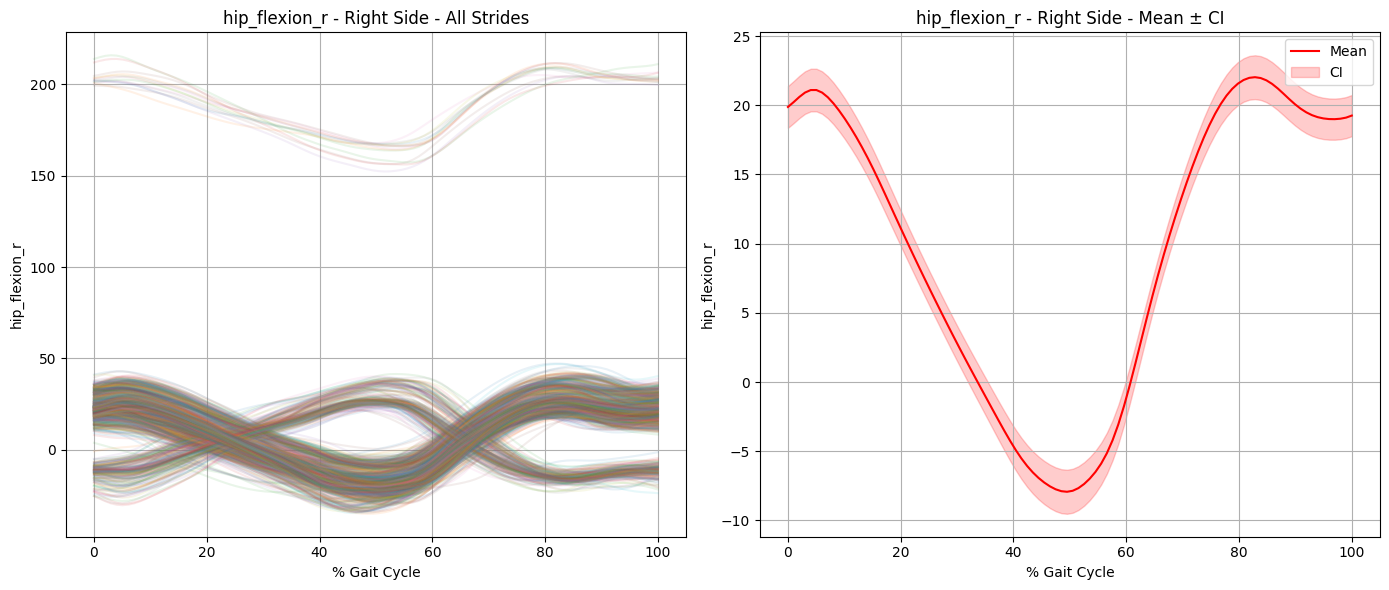

Available Headers:
- time
- pelvis_tilt
- pelvis_list
- pelvis_rotation
- pelvis_tx
- pelvis_ty
- pelvis_tz
- lumbar_extension
- lumbar_bending
- lumbar_rotation
- hip_flexion_r
- hip_adduction_r
- hip_rotation_r
- knee_angle_r
- ankle_angle_r
- subtalar_angle_r
- mtp_angle_r
- hip_flexion_l
- hip_adduction_l
- hip_rotation_l
- knee_angle_l
- ankle_angle_l
- subtalar_angle_l
- mtp_angle_l


Enter the header for which to calculate the normative mean:  hip_adduction_l


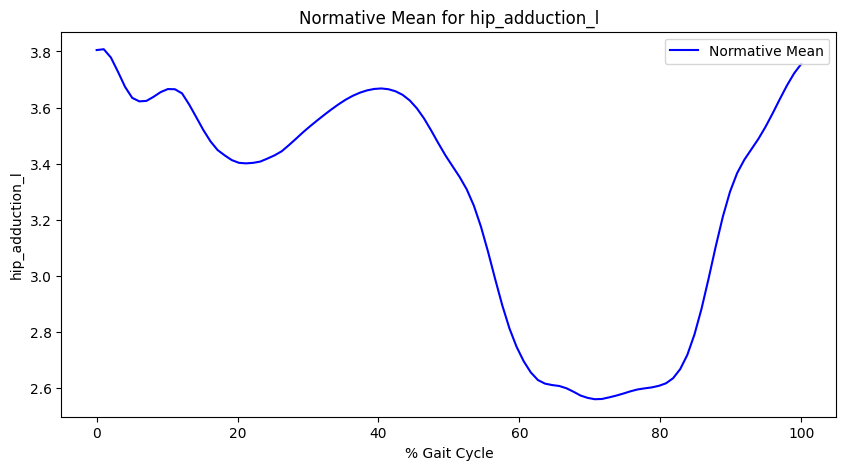

Do you approve this normative mean for saving? (yes/no):  no


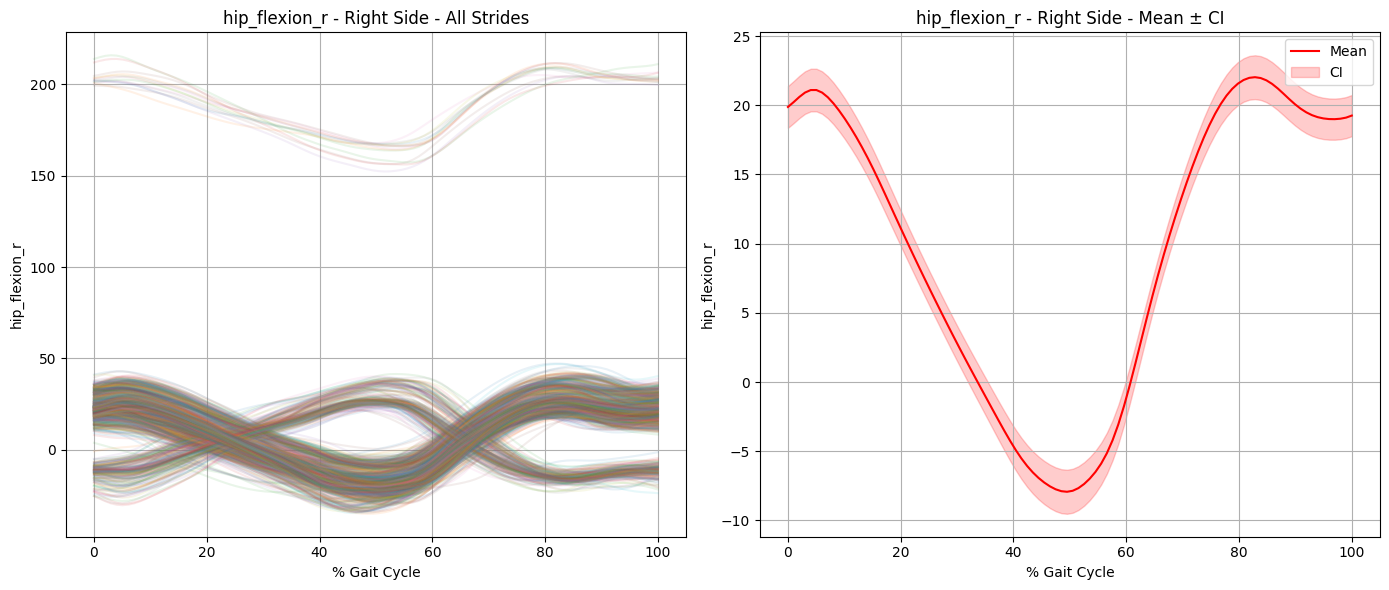

In [38]:
# Load all participant data and concatenate strides
participant_numbers = range(1, 21)  # Participants 1 to 20
all_data = load_all_participants(participant_numbers)
concatenated_data = concatenate_strides_across_participants(all_data)

# Save concatenated data
save_folder = os.path.join(base_folder, 'NormativeData')
#save_concatenated_strides(concatenated_data, save_folder)

# Visualize a header
header_to_plot = 'hip_flexion_r'
plot_concatenated_strides(concatenated_data, header_to_plot, side='Right', variability_type='CI')

# Calculate normative mean
display_headers(concatenated_data)
header = input("Enter the header for which to calculate the normative mean: ")
calculate_normative_mean(concatenated_data, header)

# Save concatenated data
#save_folder = os.path.join(base_folder, 'NormativeData')
#save_concatenated_strides(concatenated_data, save_folder)

# Visualize a header
header_to_plot = 'hip_flexion_r'
plot_concatenated_strides(concatenated_data, header_to_plot, side='Right', variability_type='CI')


In [39]:
def calculate_normative_mean(concatenated_data, header):
    """
    Calculate the normative mean for a given header across all concatenated strides.
    """
    # Construct save path
    save_path = os.path.join(normative_traces_folder, f"{header}_normative_mean.pkl")

    # Check if the normative mean is already saved
    if os.path.exists(save_path):
        with open(save_path, 'rb') as f:
            saved_mean = pickle.load(f)
            print(f"Loaded saved normative mean for '{header}'.")
            return saved_mean

    strides_r = concatenated_data[header].get('strides_r', [])
    strides_l = concatenated_data[header].get('strides_l', [])
    
    # Combine strides from both sides
    all_strides = strides_r + strides_l
    if not all_strides:
        return None
    
    # Calculate mean stride for the header
    stride_data = [stride['processed_stride_data'] for stride in all_strides]
    mean_stride = np.mean(stride_data, axis=0)

    # Visual check of the normative mean
    plt.figure(figsize=(10, 5))
    plt.plot(np.linspace(0, 100, len(mean_stride)), mean_stride, color='blue', label='Normative Mean')
    plt.title(f'Normative Mean for {header}')
    plt.xlabel('% Gait Cycle')
    plt.ylabel(header)
    plt.legend()
    plt.show()

    user_input = input("Do you approve this normative mean for saving? (yes/no): ").strip().lower()
    if user_input == 'yes':
        # Save the calculated normative mean
        with open(save_path, 'wb') as f:
            pickle.dump(mean_stride, f)
            print(f"Normative mean for '{header}' saved successfully.")

    return mean_stride

In [40]:
def save_concatenated_strides(concatenated_data, save_folder):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    save_path = os.path.join(save_folder, 'concatenated_strides.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(concatenated_data, f)
        print(f"Concatenated strides saved to '{save_path}'.")